# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import ameritrade_functions as amc
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IndHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IND']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-12 13:54:51,209|IndHoldingsAdjustement|INFO|Python version: 3.8.8
2022-11-12 13:54:51,212|IndHoldingsAdjustement|INFO|Pandas version: 1.2.4


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-12 11:53:48,607|IndHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-12 11:53:49,895|IndHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-06 00:00:00|2022-11-04 00:00:00
2022-11-12 11:53:49,924|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-12 11:53:49,978|IndHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-12 11:53:49,979|IndHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-12 11:53:50,204|IndHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-12 11:53:50,225|IndHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.018
2022-11-12 11:53:50,226|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.3
2022-11-12 11:53:50,228|IndHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-12 11:57:24,022|IndHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.86|501->430


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-12 11:57:24,062|IndHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|430
2022-11-12 11:57:24,129|IndHoldingsAdjustement|INFO|OPT_DATE|2022-11-04 00:00:00


C:\Users\HP-Z440\anaconda3\envs\ml4t\lib\site-packages\cvxpy\problems\problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2022-11-12 11:57:39,966|IndHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01800000


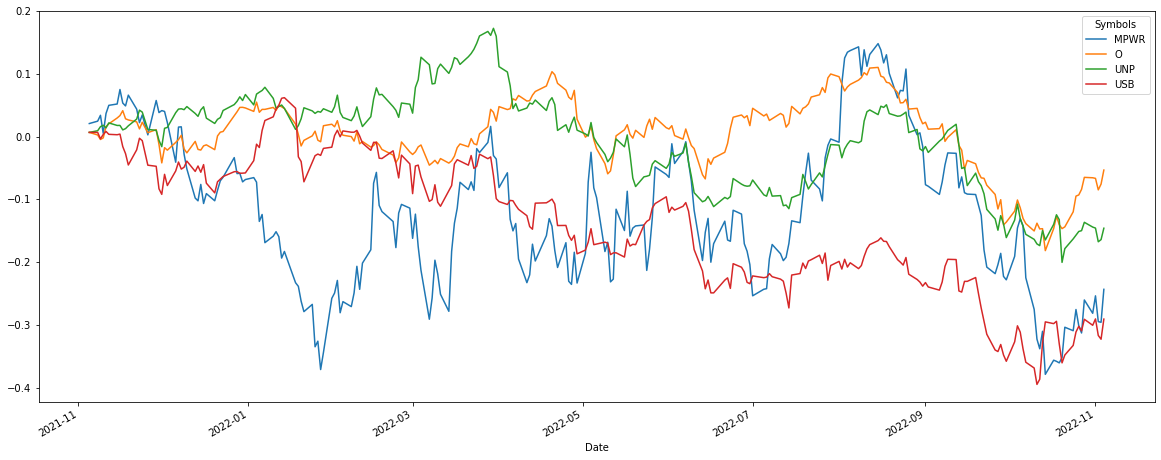

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-12 11:57:40,293|IndHoldingsAdjustement|INFO|STOCK|MPWR                |HOLDING|0.300000
2022-11-12 11:57:40,295|IndHoldingsAdjustement|INFO|STOCK|O                   |HOLDING|0.081245
2022-11-12 11:57:40,296|IndHoldingsAdjustement|INFO|STOCK|UNP                 |HOLDING|0.300000
2022-11-12 11:57:40,298|IndHoldingsAdjustement|INFO|STOCK|USB                 |HOLDING|0.300000


In [4]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

NameError: name 'long_weights' is not defined

Tickers:   0%|          | 0/4 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/4 [00:00<?, ?News Table Items/s]

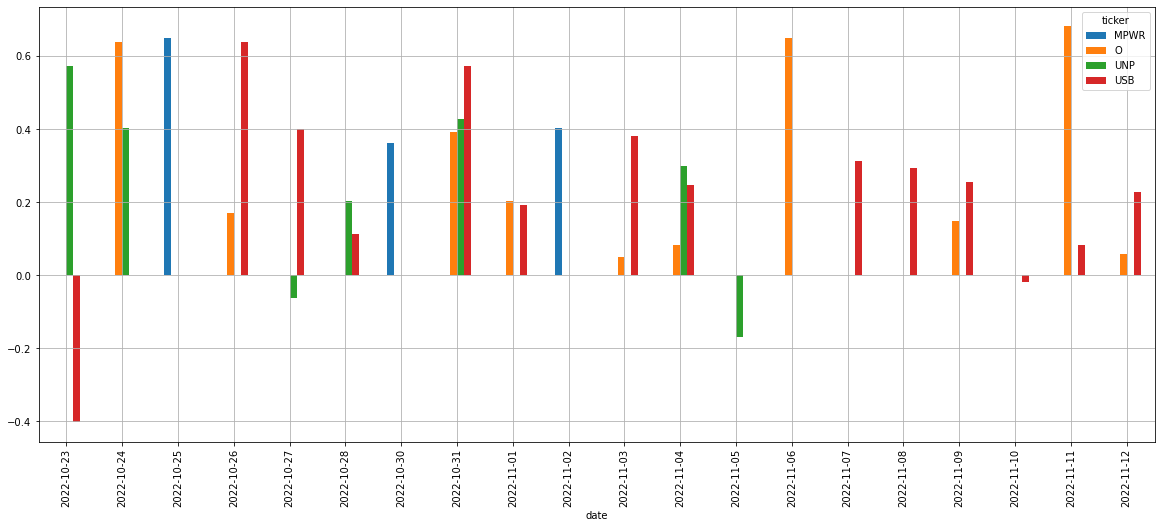

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [3]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise SystemExit
else:
    logger.info('You have authorization')

logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-12 13:56:06,475|WDM|INFO|



====== WebDriver manager ======


2022-11-12 13:56:06,477|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-12 13:56:06,517|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-12 13:56:06,520|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-12 13:56:06,585|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-12 13:56:45,773|IndHoldingsAdjustement|INFO|You have authorization
2022-11-12 13:56:45,775|IndHoldingsAdjustement|INFO|TRADE_DATE|2022-11-12 13:56:45.775074
2022-11-12 13:56:48,135|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-12 13:56:48,150|IndHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---9216 USB               0.0      43.07706             0.0   
         UNP               0.0     217.78169             0.0   
         FGPHF             0.0       0.21397             0.0   
         O                 0.0      62.94556             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---9216 USB                      0.0                             0.0   
         UNP                      0.0                             0.0   
         FGPHF                    0.0                             0.0   
         O                        0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---9216 USB           51.000               51.000                   0.0   
         UNP           11.085               11.085                   0.0   
         FGPHF       5000.000             5000.000                   0.0   
         O              9.000                9.000                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---9216 USB         2290.92                  687.28   
         UNP         2410.99                  723.30   
         FGPHF        473.70                    0.00   
         O            584.82                  175.45   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---9216 USB                          51.000    EQUITY  902973304           0   
         UNP                          11.085    EQUITY  907818108           0   
         FGPHF                      5000.000    EQUITY  Q3860H107           0   
         O                             9.000    EQUITY  756109104           0   

                type  
account  symbol       
#---9216 USB       0  
         UNP       0  
         FGPHF     0  
         O         0

In [12]:
account_portfolio.index.get_level_values('symbol').tolist()

['USB', 'UNP', 'FGPHF', 'O']

In [4]:
symbols = set(['AAPL', 'GOOG', 'USB', 'UNP'])
account_portfolio = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
current_holdings = account_portfolio[['marketValue', 'longQuantity']]
non_portfolio_symbols = symbols - set(account_portfolio.index.get_level_values('symbol').values)
non_portfolio_values = pd.DataFrame\
    .from_dict({(masked_account_number, symbol): [0, 0] for symbol in non_portfolio_symbols}, orient='index')
non_portfolio_values.index.name = 'symbol'
non_portfolio_values.columns = ['marketValue', 'longQuantity']
current_holdings.append(non_portfolio_values).sort_index()

marketValue  longQuantity
account  symbol                           
#---9216 AAPL           0.00         0.000
         FGPHF        473.70      5000.000
         GOOG           0.00         0.000
         O            584.82         9.000
         UNP         2410.99        11.085
         USB         2290.92        51.000

In [12]:
total_portfolio_value = td_ameritrade.get_market_values(masked_account_number).round(2)
display(f'Account {masked_account_number} total value:  {total_portfolio_value}')

equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
port_equi_values = utils.get_market_values(equity_investments_df)
display(port_equi_values)
total_equity_value = utils.get_account_value(port_equi_values).round(2)
display(f'Account {masked_account_number} equity value: {total_equity_value}')

symbols = utils.get_investment_symbols(port_equi_values)
port_weights_equity = utils.get_portfolio_weights(port_equi_values)
display(port_weights_equity*100)

'Account #---9216 total value:  0    1036.45\n1    2295.00\n2    2421.85\n3     487.50\n4     585.00\nName: marketValue, dtype: float64'

1    2295.00
2    2421.85
3     487.50
4     585.00
Name: marketValue, dtype: float64

KeyError: 'marketValue'

In [21]:
long_term_stocks = default_config['long_term_stocks'].split()

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(
    utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell['symbol'].isin(long_term_stocks)]
logger.info('Stocks to sell:')
display(stocks_to_sell)

,account,shortQuantity,averagePrice,currentDayCost,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,previousSessionLongQuantity,assetType,cusip,symbol,description,type
0,#---9216,0.0,85.89317,0.0,0.000000e+00,0.0,15.389,15.389,0.0,1385.63,415.69,15.389,EQUITY,209115104,ED,0,0
2,#---9216,0.0,493.84067,0.0,-1.000000e-12,0.0,5.046,5.046,0.0,2715.61,814.68,5.046,EQUITY,91324P102,UNH,0,0
3,#---9216,0.0,55.32628,0.0,0.000000e+00,0.0,20.412,20.412,0.0,818.93,245.68,20.412,EQUITY,174610105,CFG,0,0
4,#---9216,0.0,244.92035,0.0,0.000000e+00,0.0,5.085,5.085,0.0,1000.22,300.07,5.085,EQUITY,907818108,UNP,0,0


### Submit and montior sell orders

In [22]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---9216 for 15.389 shares of ED...
Placed SELL order on #---9216 for 15.389 shares of ED
Placing SELL order on #---9216 for 5.046 shares of UNH...
Placed SELL order on #---9216 for 5.046 shares of UNH
Placing SELL order on #---9216 for 20.412 shares of CFG...
Placed SELL order on #---9216 for 20.412 shares of CFG
Placing SELL order on #---9216 for 5.085 shares of UNP...
Placed SELL order on #---9216 for 5.085 shares of UNP


In [24]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [25]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance           0.000000
initialBalances_totalCash             0.000000
initialBalances_equity             5965.200000
initialBalances_moneyMarketFund      44.810000
currentBalances_cashBalance        5839.870000
currentBalances_equity             5977.640000
currentBalances_moneyMarketFund      44.810000
current_return                        0.002083
Name: #---9216, dtype: float64

5839.87
44.81


In [26]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 5884.68
Amount to invest: 5000


In [27]:
long_weights

,optimalWeights
MPWR,0.30000
O,0.08093
UNP,0.30000
USB,0.30000


In [28]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-07 09:53:24.561898
Initial investment amount: 5000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
MPWR,354.010,0.30000,1500.0,4
O,63.265,0.08093,405.0,6
UNP,197.570,0.30000,1500.0,7
USB,43.155,0.30000,1500.0,34


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
O,63.265,0.118852,594.0,9,569.385
UNP,197.570,0.440574,2203.0,11,2173.270
USB,43.155,0.440574,2203.0,51,2200.905


Total cost: 4943.5599999999995


### Place buy orders

In [29]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,902973304,USB,U.S. Bancorp Common Stock,NYSE,EQUITY,63.57,38.39,1.920,4.48,2022-09-29 00:00:00.000,...,5.83971,0.0,0.0,0.0,0.480,2022-10-17 00:00:00.000,0.97186,10405700.0,10405695.0,188970940.0
1,907818108,UNP,Union Pacific Corporation Common Stock,NYSE,EQUITY,278.94,183.70,5.200,2.64,2022-08-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,1.300,2022-09-30 00:00:00.000,1.10589,3253740.0,3253737.0,62126430.0
2,756109104,O,Realty Income Corporation Common Stock,NYSE,EQUITY,75.40,55.50,2.976,4.72,2022-10-31 00:00:00.000,...,10.25254,0.0,0.0,0.0,0.248,2022-11-15 00:00:00.000,0.78089,4191030.0,4191029.0,90296080.0


In [30]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-07 10:03:38.059187
Placing BUY order on 755579216 for 9.0 shares of O:EQUITY...
Placed BUY order on #---9216 for 9.0 shares of O
Placing BUY order on 755579216 for 11.0 shares of UNP:EQUITY...
Placed BUY order on #---9216 for 11.0 shares of UNP
Placing BUY order on 755579216 for 51.0 shares of USB:EQUITY...
Placed BUY order on #---9216 for 51.0 shares of USB


Tickers:   0%|          | 0/5 [00:00<?, ?Price Histories/s]

<AxesSubplot:xlabel='date'>

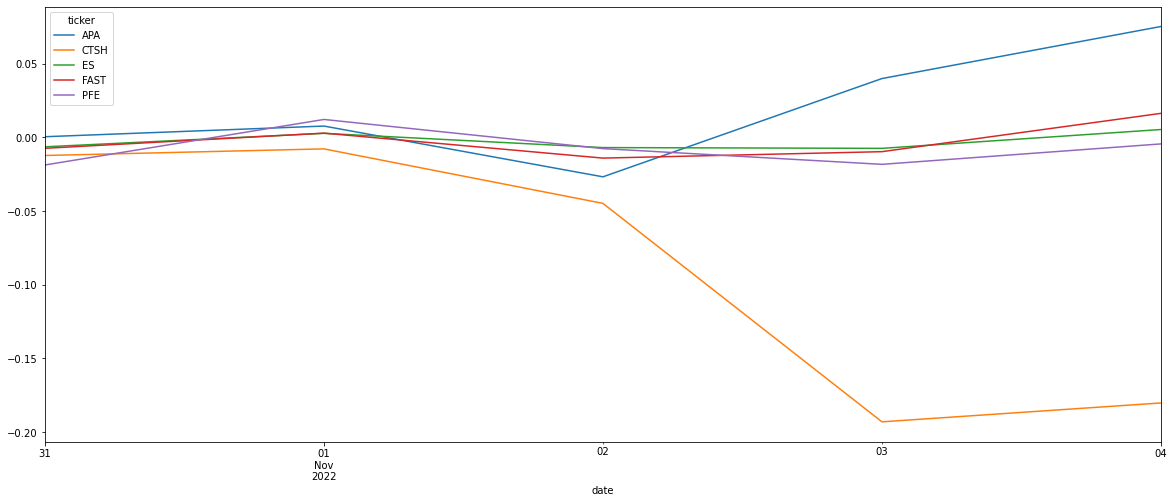

In [23]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]